In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, DQN, SAC, TD3, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import VecMonitor

env = make_vec_env("LunarLander-v3", n_envs=8)
env = VecMonitor(env, filename="lunarlander")

# hyperparam from https://huggingface.co/sb3/ppo-LunarLander-v2
model = PPO(
    "MlpPolicy",
    env=env,
    ent_coef=0.01,
    gae_lambda=0.98,
    gamma=0.999,
    verbose=True
)

model.learn(total_timesteps=300000)

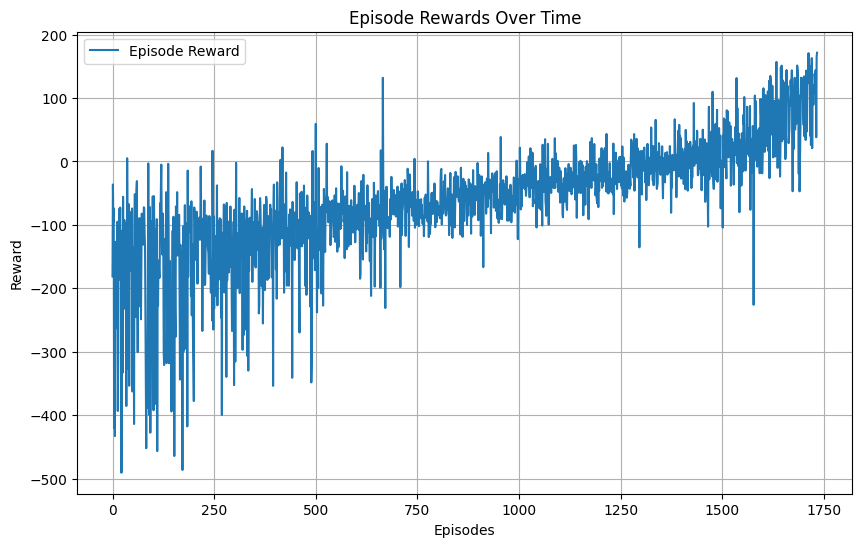

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

log_file = "lunarlander.monitor.csv"
data = pd.read_csv(log_file, skiprows=1)
episode_rewards = data["r"]

plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label="Episode Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Episode Rewards Over Time")
plt.legend()
plt.grid()
plt.show()

In [ ]:
vec_env = make_vec_env("LunarLander-v3", n_envs=1)
obs = vec_env.reset()

for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    vec_env.render("human")